In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
import scipy.optimize
import urllib
import math
from typing import Tuple
from sklearn.decomposition import PCA
from scipy import linalg as LA

In [4]:
X = np.array([[-1,1],[.5,-.5],[1,1],[-.5,.5]])
Y = np.array([[-1,0.5,1,-0.5],[1,-0.5,1,0.5]])
print(X)
X -= np.mean(X, axis = 0)
p = PCA()
p.fit(X)
print(p.components_)
print(p.components_[:,1])
print(np.var(X.dot(p.components_[:,1])))
print(p.explained_variance_)
print("----------------")
print(Y)
p = PCA(n_components=2)
p.fit(Y)
print(p.components_)
print(p.components_.T[:,1])
print(np.var(X.dot(p.components_[:,1])))
print(p.explained_variance_)

[[-1.   1. ]
 [ 0.5 -0.5]
 [ 1.   1. ]
 [-0.5  0.5]]
[[-0.92387953  0.38268343]
 [ 0.38268343  0.92387953]]
[0.38268343 0.92387953]
0.3232233047033631
[0.90236893 0.43096441]
----------------
[[-1.   0.5  1.  -0.5]
 [ 1.  -0.5  1.   0.5]]
[[ 0.81649658 -0.40824829  0.          0.40824829]
 [-0.57735027 -0.57735027  0.          0.57735027]]
[-0.57735027 -0.57735027  0.          0.57735027]
0.17024110156778774
[3.00000000e+00 3.46105015e-34]


In [5]:
X = np.array([[-1,1],[.5,-.5],[1,1],[-.5,.5]])
X -= np.mean(X, axis = 0)  
newX = np.copy(X)
symMatrix = (np.dot(np.transpose(newX),newX)) #create symmetric matrix K

#eigen decomposition
eigVals, eigVects = np.linalg.eig(symMatrix)

print(eigVects)

[[ 0.92387953  0.38268343]
 [-0.38268343  0.92387953]]


In [32]:
X = np.array([[-1,1],[.5,-.5],[1,1],[-.5,.5]])
X -= np.mean(X, axis = 0)  

cov = np.cov(X, rowvar = False)

evals , evecs = LA.eigh(cov)
print(evals)
print(evecs)
print(evecs[:,1])
print(np.var(X.dot(evecs[:,1])))

[0.43096441 0.90236893]
[[-0.38268343 -0.92387953]
 [-0.92387953  0.38268343]]
[-0.92387953  0.38268343]
0.676776695296637


# Part 1 - Principal Component Analysis

## Part 1.1 - Implement PCA

In [34]:
def pca(X: np.ndarray, K: int) -> Tuple[np.ndarray, np.ndarray,  np.ndarray]:
    """
    X is an N*D matrix of data (N points in D dimensions)
    K is the desired maximum target dimensionality (K <= min{N,D})

    should return a tuple (P, Z, evals)
    
    where P is the projected data (N*K) where
    the first dimension is the highest variance,
    the second dimension is the second higest variance, etc.

    Z is the projection matrix (D*K) that projects the data into
    the low dimensional space (i.e., P = X * Z).

    and evals, a K dimensional array of eigenvalues (sorted)
    """
    
    N, D = X.shape

    # make sure we don't look for too many eigs!
    if K > N:
        K = N
    if K > D:
        K = D

    ### TODO: YOUR CODE HERE
    #center the data so the mean is 0
    means = X.mean(axis=0) #array of means of every column
    newX = np.copy(X)
    a, b = newX.shape
    for i in range(a):
        for j in range(b):
            newX[i,j] = newX[i,j] - means[j] #subtract mean from every column
    
    #x_T * x
    symMatrix = (np.dot(np.transpose(newX),newX)) #create symmetric matrix K
    
    #eigen decomposition
    eigVals, eigVects = np.linalg.eigh(symMatrix)

    
    P = np.dot(X,np.transpose(eigVects))
    P = P[:,:K]
    Z = eigVects[:,:K]
    Z = Z.T
    evals = eigVals[:K]
    return (P, Z, evals)

A = np.array([[1, 4, 5], [5, 8, 9]],dtype=np.float64)
B = np.array([[1,2], [2,1]])
nP, nZ, nEv = pca(A,2)
#print(nEv)
X = np.array([[-1,1],[.5,-.5],[1,1],[-.5,.5]])
Y = np.array([[-1,0.5,1,-0.5],[1,-0.5,1,0.5]])
nP, nZ, nEv = pca(X,2)

print(nZ)
print(nZ[:,1].T)
print(X.dot(nZ[:,1]))
print(np.var(X.dot(nZ[:,1])))
print("--------")


[[-0.38268343 -0.92387953]
 [-0.92387953  0.38268343]]
[-0.92387953  0.38268343]
[ 1.30656296 -0.65328148 -0.5411961   0.65328148]
0.676776695296637
--------


Our first test of PCA will be on Gaussian data with a known covariance matrix. First, let's generate some data and see how it looks.

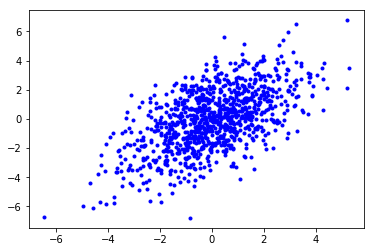

In [3]:
M = np.array([[3,2],[2,4]])
(U,S,VT) = np.linalg.svd(M)
D = np.diag(np.sqrt(S))

Si = U @ D @ VT
x = np.random.randn(1000,2) @ Si
plt.plot(x[:,0], x[:,1], 'b.');

We can also see what the sample covariance is!

In [4]:
np.cov(x.T)

array([[2.83237761, 2.03292077],
       [2.03292077, 4.27349726]])

Note that the sample covariance of the data is almost exactly the true covariance of the data. If you run this with 100,000 data points (instead of 1,000), you should get something even closer to 
$\begin{bmatrix} 3 & 2 \\ 2 & 4 \end{bmatrix}$.

Now, let's run PCA on this data. We basically know what should happen, but let's make sure it happens anyway (still, given the random nature, the numbers won't be exactly the same). We can project the data onto the first eigenvalue and plot it in red, and the second eigenvalue in green. 

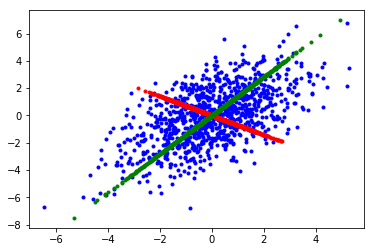

In [5]:
(P, Z, evals) = pca(x, 2)

x0 = (x @ Z[:,0,None]) * Z[:,0,None].T
x1 = (x @ Z[:,1,None]) * Z[:,1,None].T

plt.plot(x[:,0], x[:,1], 'b.', x0[:,0], x0[:,1], 'r.', x1[:,0], x1[:,1], 'g.');

## Part 1.2 - Visualization of MNIST

Lets work with some [handwritten digits](https://en.wikipedia.org/wiki/MNIST_database). Before we try PCA on them, let's visualize the digits.

In [6]:
np.random.seed(0)

def draw_digits(X: np.ndarray, Y: np.ndarray, K: int = 20):
    ### TODO: YOUR CODE HERE
    #raise NotImplementedError
    xDim, yDim = X.shape
    #print(X.shape)
    digitInds = np.random.choice(xDim, K, False)
    #print(X[0])
    for i in range(K):
        print(Y[digitInds[i]])
        #digit = np.reshape(X[digitInds[i]], (28, 28))*255
        digit = X[digitInds[i]].reshape(28,28)
        digit = np.transpose(digit)
        plt.imshow(digit, cmap='gray')
        plt.show()

0


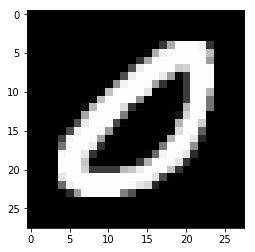

9


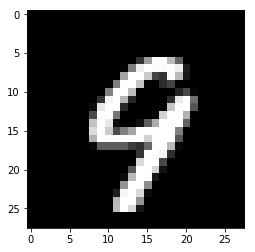

3


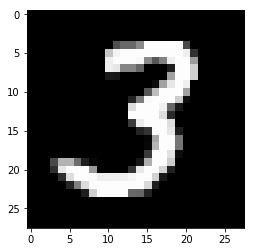

6


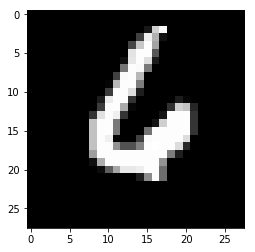

7


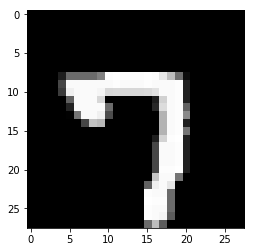

0


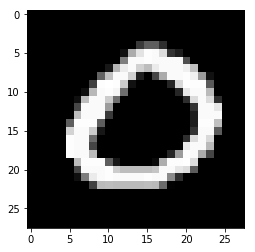

1


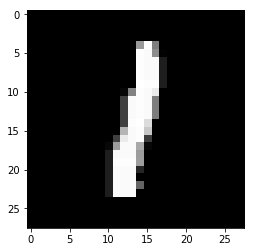

3


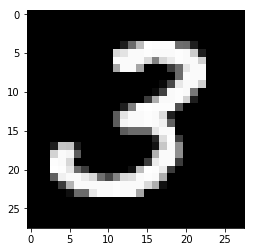

4


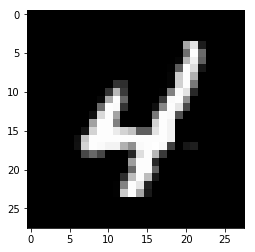

8


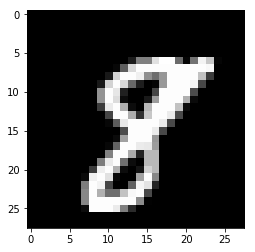

5


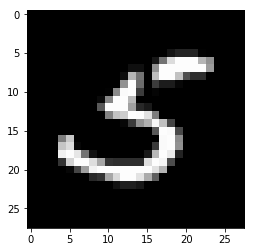

6


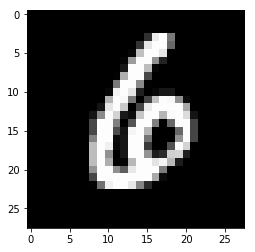

8


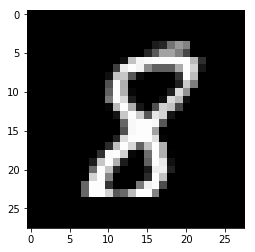

3


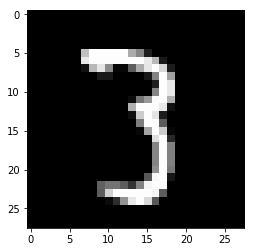

6


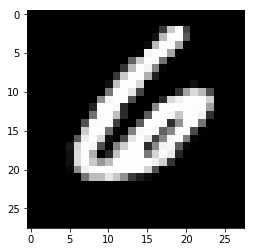

1


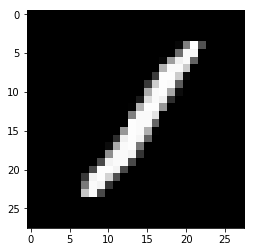

0


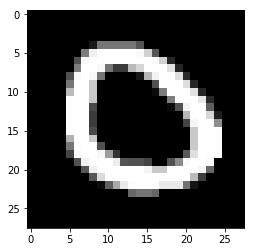

2


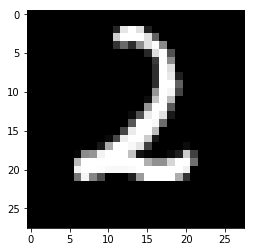

1


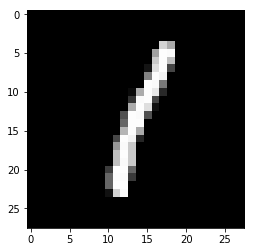

1


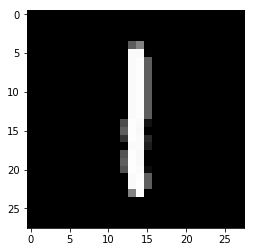

In [7]:
def load_digits():
    X = np.zeros((1000, 784), dtype=float)
    Y = np.zeros((1000,), dtype=int)

    with open('data/digits') as f:
        for idx, line in enumerate(f):
            vals = [int(v) for v in line.split()]
            Y[idx] = vals[0] % 10
            for i in range(len(vals)//2-1):
                X[idx, vals[i*2+1]] = float(vals[i*2+2])
            X[idx,:] = X[idx,:] / np.linalg.norm(X[idx,:])

    return X, Y

X, Y = load_digits()
draw_digits(X, Y)

## 1.3 - Plotting Explained Variance

Let's examine all the principal components of the digits data.

Plot the explained variance of the principal components, with x-axis being the number of principal components, and the y-axis being the percent variance explained. How many eigenvectors do you have to include before you've accounted for 90% of the variance?
95%?

598.7637570955633
9.168081494057725


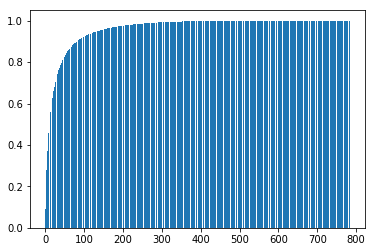

In [8]:
(P, Z, evals) = pca(X, 784)
d = evals.shape
xVals = np.arange(len(evals))
yVals = np.arange(len(evals), dtype='f')
totalVar = np.sum(evals)
print(totalVar)
print((54/589)*100)
#print(np.arange(1,d[0]))
for i in range(len(evals)):
    if i == 0:
        xVals[i] = i
        #yVals[i] = (evals[783-i] / totalVar)*100
        yVals[i] = (evals[783-i])
    else:
        xVals[i] = i
        #yVals[i] = yVals[i-1] + ((evals[783-i]/totalVar)*100)
        yVals[i] = yVals[i-1] + ((evals[783-i])) + 0.0
        
    #print(xVals[i], " ", yVals[i]," ",evals[783-i])
    
yVals = yVals / totalVar
plt.bar(xVals, yVals)
plt.show()

Eventually, the eigenvalues drop to zero (note that some may be negative due to floating point errors).

**ANSWER**:

## Part 1.4 - Visualization of Dimensionality Reduction

Now, let's plot the top 50 eigenvectors:

36


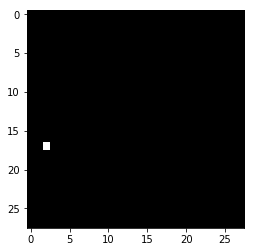

49


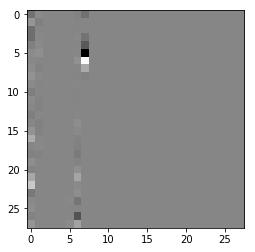

48


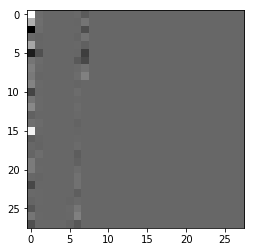

47


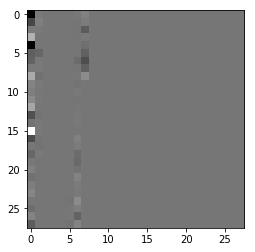

6


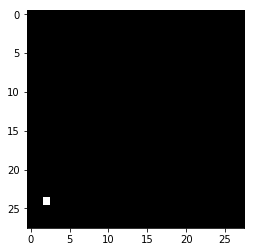

19


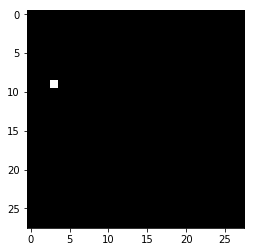

2


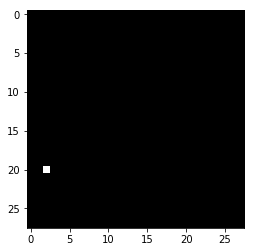

32


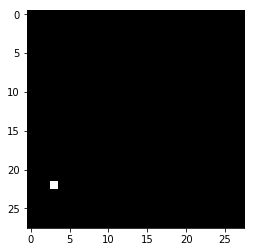

39


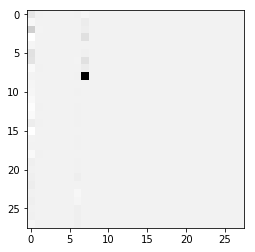

31


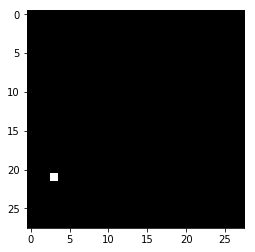

13


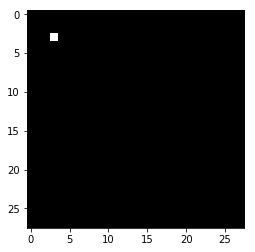

20


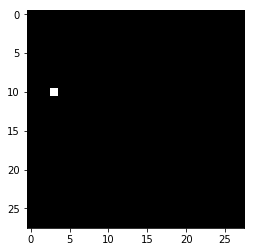

12


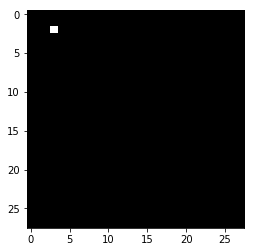

5


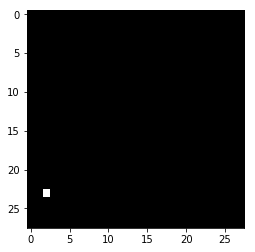

23


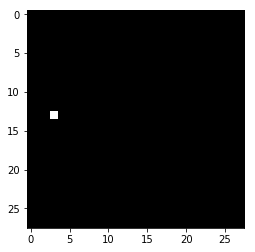

10


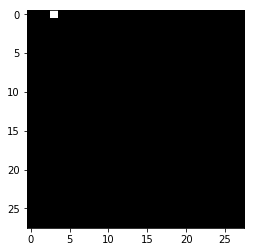

40


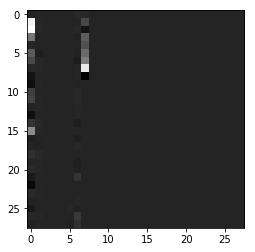

15


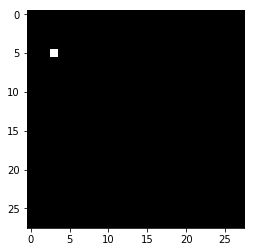

17


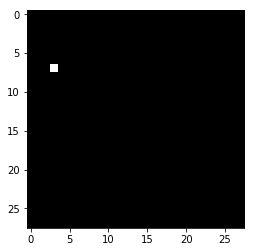

33


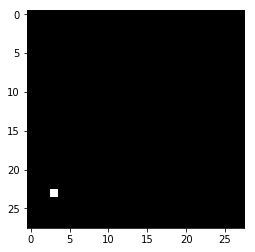

In [9]:
draw_digits(Z.T[:50,:], np.arange(50))

# Part 2 - Softmax Regression

The goal of this part of the project is to implement Softmax Regression in order to classify the MNIST digit dataset. Softmax Regression is essentially a two-layer neural network where the output layer applies the Softmax cost function, a multiclass generalization of the logistic cost function.

In logistic regression, we have a hypothesis function of the form

$$\mathbb{P}[y=1] = \frac{1}{1 + e^{-wx}}$$

where $\mathbf{w}$ is our weight vector. Like the hyperbolic tangent function, the logistic function is also a sigmoid function with the characteristic 's'-like shape, though it has a range of $(0, 1)$ instead of $(-1, 1)$. Note that this is technically not a classifier since it returns probabilities instead of a predicted class, but it's easy to turn it into a classifier by simply choosing the class with the highest probability.

Since logistic regression is used for binary classification, it is easy to see that:

$$\begin{aligned}
\mathbb{P}[y=1] &= \frac{1}{1 + e^{-wx}} \\
&= \frac{e^{wx}}{e^{wx} + e^{0 \cdot x}} \\
\end{aligned}$$

Similarily,

$$\begin{aligned}
\mathbb{P}[y=0] &= 1 - \mathbb{P}[y=1] \\
&= 1 - \frac{e^{wx}}{1 + e^{wx}} \\
&= \frac{e^{0 \cdot x}}{e^{wx} + e^{0 \cdot x}} \\
\end{aligned}$$

From this form it appears that we can assign the vector $w_1 = w$ as the weight vector for class $1$ and $w_0 = \vec{0}$ as the weight vector for class $0$. This motivates generalization to classification with more than 2 classes. By assigning a separate weight vector $w_i$ to each class, for each example $x$ we can predict the probability that it is class $i$, and again we can classify by choosing the most probable class.

$$\mathbb{P}[y=i] = \frac{e^{w_i x}}{\sum\limits_j e^{w_j x}}$$

A more compact way of representing the values $w_i x$ is $Wx$ where each row $i$ of $W$ is $w_i$. We can also represent a dataset $\{x_i\}$ with a matrix $X$ where each column is a single example, resulting in $WX$.

## Part 2.2 - Implementing a Softmax Classifier
We can also train on this model with an appropriate loss function. The Softmax loss function is given by

$$\xi(W) = -\sum\limits_{i=1}^{n}\sum\limits_{j=1}^{C}\delta_{y_i,j}\log \mathbb{P}(y_i = j)$$

where $n$ is the number of samples, $C$ is the number of classes, $\delta_{y_i,j}$ is the [kronecker delta](https://en.wikipedia.org/wiki/Kronecker_delta), $y_i$ is the label of sample $i$, and $\mathbb{P}(y_i = j)$ is calculated using a softmax function using the weights from matrix $W$.

Note that 

$$\delta_{y_i,j} = \begin{cases}1 &\text{if } y_i = j \\ 0 & \text{if } y_i \neq j\end{cases}$$

The gradient of this function is given by 

$$\nabla_{\vec{w_j}} \xi(W) = \sum_{i=1}^{n}{ \left[ x_i \left( \mathbb{P}[y_i = j] - \delta_{y_i, j} \right) \right]}$$

The derivation for this can be found in the references. Note that the kronecker delta and the probabilities can be represented as matrices, which makes the code for the loss and the gradient very simple.

In [10]:
class SoftmaxRegression:
    """
    Here you will fill in this incomplete implementation of Softmax regression.

    Adapted from code by Jatin Shah
    """
    def __init__(self, num_classes, ex_size, opts={'maxIter':400}):
        """
        num_classes:    number of possible classifications
        ex_size:        size of attribute array (number of input features)
        reg:            regularizing term coefficient (lambda)
        opts:           in this class the only option used is maxIter
        """

        self.num_classes = num_classes
        self.ex_size = ex_size
        self.opts = opts

        # Initialize weight matrix with empty matrix
        self.W = np.zeros((num_classes, ex_size))


    def cost(self, X, Y, W=None):
        """
        Calculate the cost function for X and Y using current weight matrix W. Note that we are not using
        a regularizer in the cost; this is equivalent to lambda = 0.

        X:              (M x N) matrix of input feature values,
                            where M = ex_size, N = number of examples
        Y:              (N x 1) array of expected output classes for each example

        Returns the cost and its gradient, which is the form needed to use scipy.optimize.minimize
        """

        if W is None:
            W = this.W
        num_classes = self.num_classes
        ex_size = self.ex_size

        W = W.reshape(num_classes, ex_size)         # Ensure W is in the correct dimensions
        N = X.shape[1]                              # N = number of examples
        #print(W.shape)
        #print(X.shape)

        W_X = W.dot(X)                              # This is our activation matrix with dimensions (A * B)
                                                    # where A is the number of classes and B is the number
                                                    # of examples. (W_X[a, b] gives the activation of example
                                                    # b for class a.) You will use this matrix to find the
                                                    # probabilities that example b is class a using the
                                                    # softmax formula.

        W_X = W_X - np.amax(W_X)
        print(W_X.shape)

        # This is the indicator function used in the loss function, where indicator[a, b] = 1
        # when example b is labeled a (according to the target Y) and indicator[a, b] = 0 otherwise.

        indicator = scipy.sparse.csr_matrix((np.ones(N), (Y, np.array(range(N)))))
        indicator = np.resize(np.array(indicator.todense()), (num_classes, N))


        # Each row of W_X is the set of activations for each class corresponding to
        # one example; the probabilties are given by the exponential of each entry
        # divided by the sum of the exponentials over the entire column.

        # The cost associated with a single example is given by -1 times the log probability
        # of the true class; initialize the cost variable to the AVERAGE cost over all the examples.
        # Hint: there's an easy way to do this with the indicator matrix.

        # The gradient has the same dimensions as W, and each component (i,j) represents the
        # derivative of the cost with respect to the weight associated with class i, attribute j.
        # The gradient associated with a single example x is given by A * x_T, where x_T is
        # the transpose of the example, and A is a vector with component i given by (P(class = i) - 1)
        # if the true class is i, and (P(class = i)) otherwise. Notice that this multiplication gives
        # the desired dimensions. Find the AVERAGE gradient over all the examples. Again, there is
        # an easy way to do this with the indicator matrix.


        # calculate probabilities for each class(row) for each example(col). sum each column and divide by that sum
        a,b = W_X.shape
        probabilities = np.zeros(W_X.shape)
        #preProb = np.zeros(W_X.shape)
        #probabilities = probabilities.reshape(num_classes, ex_size)
        #print(probabilities.shape)
        #probabilities = np.exp(W_X)
        #probabilities = probabilities / np.sum(probabilities)
        
        for i in range(a):
            for j in range(b):
                probabilities[i, j] = math.exp(W_X[i,j])
                #preProb[i,j] = probabilities[i,j]
                
        
        totals = probabilities.sum(axis=0)
        #print(X)
        #print("prob", probabilities)
        #print("totals", totals)
        
        for i in range(a):
            for j in range(b):
                probabilities[i, j] = probabilities[i,j] / totals[j]
        
                
        #print("prob",probabilities)
        
        #print("ind",indicator.shape)
        print("haha")
        # cost =
        cost = 0;
        for i in range(a):
            for j in range(b):
                cost += (-1)*(indicator[i,j])*math.log(probabilities[i, j])
        
        cost = (1/(N))*(cost)
        print("cost",cost)
        gradient = probabilities - indicator
        gradient = gradient.dot(X.T)
        gradient = (1/N)*gradient
        


        # flatten is needed by scipy.optimize.minimize
        return cost, gradient.flatten()


    def train(self, X, Y):
        """
        Train to find optimal weight matrix W. Here we make use of the SciPy optimization library but
        in theory you could implement gradient descent to do this as well.

        X:              (M x N) matrix of input feature values,
                            where M = ex_size, N = number of examples
        Y:              (N x 1) array of expected output classes for each example
        maxIter:        Maximum training iterations
        """

        num_classes = self.num_classes
        ex_size = self.ex_size
        W = self.W

        # Set maxIter hyperparameter
        if self.opts['maxIter'] is None:
            self.opts['maxIter'] = 400

        # Lambda function needed by scipy.optimize.minimize
        J = lambda w: self.cost(X, Y, w)

        result = scipy.optimize.minimize(J, W, method='L-BFGS-B', jac=True, options={'maxiter': self.opts['maxIter'], 'disp': True})
        self.W = result.x # save the optimal solution found

    def predict(self, X):
        """
        Use W to predict the classes of each example in X.

        X:              (M x N) matrix of input feature values,
                            where M = ex_size, N = number of examples

        """

        W = self.W.reshape(self.num_classes, self.ex_size)
        W_X = W.dot(X)

        # Reminder: The predicted class for a single example is just the one with the highest probability

        a, b = W_X.shape
        predicted_classes = np.zeros(b)
        for i in range(b):
            maxVal = W_X[0,i]
            predClass = 0
            for j in range(a):
                if(maxVal < W_X[j,i]):
                    maxVal = W_X[j,i]
                    predClass = j
            predicted_classes[i] = predClass 

        return predicted_classes
ex = SoftmaxRegression(3,3)
A = np.array([[1, 4, 5], [5, 8, 9],[6,2,5]]) 
B = np.array([1,2,3])
C = np.array([[0.5,0.5,0.5], [0.5,0.5,0.5], [0.5,0.5,0.5]]) 
ex.cost(A, B, C)
ex.predict(A)

(3, 3)
haha
cost 0.7324081924454063


array([0., 0., 0.])

In [11]:
def good_job(path):
    a = plt.imread(urllib.request.urlopen(path))
    fig = plt.imshow(a)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.show()

def loadMNIST(image_file, label_file):
    """
    returns a 28x28x[number of MNIST images] matrix containing
    the raw MNIST images
    :param filename: input data file
    """

    with open(image_file, "r") as f:
        magic = np.fromfile(f, dtype=np.dtype('>i4'), count=1)

        num_images = np.fromfile(f, dtype=np.dtype('>i4'), count=1)[0]
        num_rows = np.fromfile(f, dtype=np.dtype('>i4'), count=1)[0]
        num_cols = np.fromfile(f, dtype=np.dtype('>i4'), count=1)[0]

        exSize = num_rows * num_cols
        images = np.fromfile(f, dtype=np.ubyte)
        images = images.reshape((num_images, exSize)).transpose()
        images = images.astype(np.float64) / 255

    with open(label_file, 'r') as f:
        magic = np.fromfile(f, dtype=np.dtype('>i4'), count=1)
        num_labels = np.fromfile(f, dtype=np.dtype('>i4'), count=1)
        labels = np.fromfile(f, dtype=np.ubyte)

    return images, labels

ex_size = 28*28   # size of MNIST digits
num_classes = 10  # 10 digits to classify

X, Y = loadMNIST('data/train-images.idx3-ubyte', 'data/train-labels.idx1-ubyte')
testX, testY = loadMNIST('data/t10k-images.idx3-ubyte', 'data/t10k-labels.idx1-ubyte')

(10, 60000)
haha
cost 2.3025850929954172
(10, 60000)
haha
cost 1.529097449969396
(10, 60000)
haha
cost 0.772037807684184
(10, 60000)
haha
cost 0.7111494694033672
(10, 60000)
haha
cost 0.5955845602739355
(10, 60000)
haha
cost 0.5502681697186218
(10, 60000)
haha
cost 0.5013050412538258
(10, 60000)
haha
cost 0.4815800848917949
(10, 60000)
haha
cost 0.4531674531979173
(10, 60000)
haha
cost 0.4402238077570821
(10, 60000)
haha
cost 0.42669523265661763
(10, 60000)
haha
cost 0.4091141293935287
(10, 60000)
haha
cost 0.389559470346911
(10, 60000)
haha
cost 0.3689076135177881
(10, 60000)
haha
cost 0.35826476289722625
(10, 60000)
haha
cost 0.34953732177484387
(10, 60000)
haha
cost 0.3442162540258366
(10, 60000)
haha
cost 0.33897711253570256
(10, 60000)
haha
cost 0.33015497824355355
(10, 60000)
haha
cost 0.32660559090298297
(10, 60000)
haha
cost 0.3219482855203463
(10, 60000)
haha
cost 0.3181464797377983
(10, 60000)
haha
cost 0.3128594201588309
(10, 60000)
haha
cost 0.30921171170953077
(10, 60000)


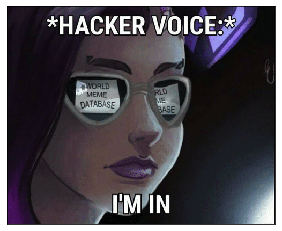

In [12]:
sm = SoftmaxRegression(num_classes, ex_size)
sm.train(X, Y)

predictions = sm.predict(testX)
accuracy = 100 * np.sum(predictions == testY, dtype=np.float64) / testY.shape[0]
print(f"Accuracy: {accuracy:.2f}")
assert accuracy >= 92, "Implementation is sadly incorrect :("

print("TEST PASSED!!!")
good_job("hacker_database.png")

## 2.4 - Analysis of Classifier Accuracy

In [99]:
def train_test(classifier, X, Y, Xtest, Ytest):
    """
    Train a classifier on data (X,Y) and evaluate on
    data (Xtest,Ytest).  Return a tuple of:
      * Training data accuracy
      * Test data accuracy
    """
    classifier.train(X, Y)
    train_acc = np.mean(Y == classifier.predict(X))
    test_acc = np.mean(Ytest == classifier.predict(Xtest))

    print(f"Training accuracy {train_acc}, test accuracy {test_acc}")

    return train_acc, test_acc

def learning_curve(classifier, X, Y, Xtest, Ytest):
    """
    Generate a learning curve by repeatedly halving the amount of
    training data until none is left.

    We return a triple containing:
      * The sizes of data sets we trained on
      * The training accuracies at each level
      * The test accuracies at each level
    """

    N = X.shape[1]                   # how many total points?
    M = int(np.ceil(np.log2(N)))     # how many classifiers will we have to train?

    data_sizes = np.zeros(M)
    train_accs  = np.zeros(M)
    test_accs   = np.zeros(M)

    for i in range(1, M+1):
        # select every 2^(M-i)th point
        ids = np.arange(0, N, 2**(M-i))
        Xtr = X[:, ids]
        Ytr = Y[ids]

        # report what we're doing
        print(f"Training classifier on {ids.size} points...")

        # train the classifier
        train_acc, test_acc = train_test(classifier, Xtr, Ytr, Xtest, Ytest)

        # store the results
        data_sizes[i-1] = ids.size
        train_accs[i-1] = train_acc
        test_accs[i-1]  = test_acc

    return (data_sizes, train_accs, test_accs)